In [ ]:
import os
import joblib
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
# from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Get path from training and test dataset

curr_path = os.getcwd()
dataset_src = os.path.join(curr_path, 'dataset')
train_path = os.path.join(dataset_src, 'train.csv')
test_path = os.path.join(dataset_src, 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
# Missing values?

train_df.info()



In [ ]:
print(train_df.isnull().sum())
print('-----------')
print('-----------')
print(test_df.isnull().sum())

In [ ]:
print(train_df.Age.isnull().sum() / len(train_df))

In [ ]:
'''
Only 20% of the age data is missing. So, we need to fill the missing values. To do so, we can apply different methodologies:
- Take the mean of the age values
- Take random number with a normal law N(mean, std deviation) of the age
- Split the people in smaller group and then take the mean of these subgroups using categorical features - > the one I chose.
- Split the people in smaller group and then take random number with a normal law N(mean, std deviation) of the age within each subgroup

We'll use the third one.
'''

sns.distplot(train_df.Age.fillna(200))

In [ ]:
list_features = test_df.columns
print('They are',len(list_features),'features in the dataset.')
print('----------------')
for f in list_features:
    print('feature:', f, '|| Type:', type(train_df[f][0]), '|| Example:', train_df[f][0], '|| number of unique values', len(train_df[f].unique()) )

In [ ]:
# CATEGORICAL AND INTEGER NUMERICAL

# Lets see the transported people following the categorical features

train_df[['HomePlanet', 'Transported']].groupby('HomePlanet').mean().sort_values(by='Transported', ascending=False)

In [ ]:
train_df[['CryoSleep', 'Transported']].groupby('CryoSleep').mean().sort_values(by='Transported', ascending=False)

In [ ]:
train_df[['VIP', 'Transported']].groupby('VIP').mean().sort_values(by='Transported', ascending=False)

In [ ]:
train_df[['Destination', 'Transported']].groupby('Destination').mean().sort_values(by='Transported', ascending=False)

In [ ]:
sns.distplot(train_df.Age.dropna())

In [ ]:
sns.distplot(train_df.CryoSleep.dropna())

In [ ]:
num = sns.FacetGrid(train_df, col='Transported')
print(num.map(plt.hist, 'Age', bins=40))


In [ ]:
# num = sns.FacetGrid(train_df, col='Transported')
# print(num.map(plt.hist, 'CryoSleep', bins=10))

In [ ]:
# FEATURE ENGINERRING

In [ ]:
# Get raide of it
# train_df.drop('PassengerId', axis = 1, inplace = True)
# test_df.drop('PassengerId', axis = 1, inplace = True)

In [ ]:
train_df.nunique()


In [ ]:
train_df.dtypes

In [ ]:
train_df['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

In [ ]:
# Continuous Features

# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

In [ ]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [ ]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train_df, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [ ]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train_df[qual_feats].head()

In [ ]:
# New features - training set
train_df['Age_group']=np.nan
train_df.loc[train_df['Age']<=12,'Age_group']='Age_0-12'
train_df.loc[(train_df['Age']>12) & (train_df['Age']<18),'Age_group']='Age_13-17'
train_df.loc[(train_df['Age']>=18) & (train_df['Age']<=25),'Age_group']='Age_18-25'
train_df.loc[(train_df['Age']>25) & (train_df['Age']<=30),'Age_group']='Age_26-30'
train_df.loc[(train_df['Age']>30) & (train_df['Age']<=50),'Age_group']='Age_31-50'
train_df.loc[train_df['Age']>50,'Age_group']='Age_51+'

# New features - test set
test_df['Age_group']=np.nan
test_df.loc[test_df['Age']<=12,'Age_group']='Age_0-12'
test_df.loc[(test_df['Age']>12) & (test_df['Age']<18),'Age_group']='Age_13-17'
test_df.loc[(test_df['Age']>=18) & (test_df['Age']<=25),'Age_group']='Age_18-25'
test_df.loc[(test_df['Age']>25) & (test_df['Age']<=30),'Age_group']='Age_26-30'
test_df.loc[(test_df['Age']>30) & (test_df['Age']<=50),'Age_group']='Age_31-50'
test_df.loc[test_df['Age']>50,'Age_group']='Age_51+'

# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=train_df, x='Age_group', hue='Transported', order=['Age_0-12','Age_13-17','Age_18-25','Age_26-30','Age_31-50','Age_51+'])
plt.title('Age group distribution')

In [ ]:
# New features - training set
train_df['Expenditure']=train_df[exp_feats].sum(axis=1)
train_df['No_spending']=(train_df['Expenditure']==0).astype(int)

# New features - test set
test_df['Expenditure']=test_df[exp_feats].sum(axis=1)
test_df['No_spending']=(test_df['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_df, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train_df, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

In [ ]:
# Extract passenger group and group size from PassengerId.

# New feature - Group
train_df['Group'] = train_df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test_df['Group'] = test_df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train_df['Group_size']=train_df['Group'].map(lambda x: pd.concat([train_df['Group'], test_df['Group']]).value_counts()[x])
test_df['Group_size']=test_df['Group'].map(lambda x: pd.concat([train_df['Group'], test_df['Group']]).value_counts()[x])

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train_df, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train_df, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

In [ ]:
'''
We can't really use the Group feature in our models because it has too big of a cardinality (6217) and would explode the number of dimensions with one-hot encoding.

The Group size on the other hand should be a useful feature. In fact, we can compress the feature further by creating a 'Solo' column that tracks whether someone is travelling on their own or not. The figure on the right shows that group size=1 is less likely to be transported than group size>1.
'''

# New feature
train_df['Solo']=(train_df['Group_size']==1).astype(int)
test_df['Solo']=(test_df['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train_df, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
plt.ylim([0,3000])

In [ ]:
# Replace NaN's with outliers for now (so we can split feature)
train_df['Cabin'].fillna('Z/9999/Z', inplace=True)
test_df['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train_df['Cabin_deck'] = train_df['Cabin'].apply(lambda x: x.split('/')[0])
train_df['Cabin_number'] = train_df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train_df['Cabin_side'] = train_df['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test_df['Cabin_deck'] = test_df['Cabin'].apply(lambda x: x.split('/')[0])
test_df['Cabin_number'] = test_df['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test_df['Cabin_side'] = test_df['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train_df.loc[train_df['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train_df.loc[train_df['Cabin_number']==9999, 'Cabin_number']=np.nan
train_df.loc[train_df['Cabin_side']=='Z', 'Cabin_side']=np.nan
test_df.loc[test_df['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test_df.loc[test_df['Cabin_number']==9999, 'Cabin_number']=np.nan
test_df.loc[test_df['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train_df, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train_df, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train_df, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()

In [ ]:
'''
This is interesting! It appears that Cabin_number is grouped into chunks of 300 cabins. This means we can compress this feature into a categorical one, which indicates which chunk each passenger is in.

Other notes: The cabin deck 'T' seems to be an outlier (there are only 5 samples).
'''

# New features - training set
train_df['Cabin_region1']=(train_df['Cabin_number']<300).astype(int)   # one-hot encoding
train_df['Cabin_region2']=((train_df['Cabin_number']>=300) & (train_df['Cabin_number']<600)).astype(int)
train_df['Cabin_region3']=((train_df['Cabin_number']>=600) & (train_df['Cabin_number']<900)).astype(int)
train_df['Cabin_region4']=((train_df['Cabin_number']>=900) & (train_df['Cabin_number']<1200)).astype(int)
train_df['Cabin_region5']=((train_df['Cabin_number']>=1200) & (train_df['Cabin_number']<1500)).astype(int)
train_df['Cabin_region6']=((train_df['Cabin_number']>=1500) & (train_df['Cabin_number']<1800)).astype(int)
train_df['Cabin_region7']=(train_df['Cabin_number']>=1800).astype(int)

# New features - test set
test_df['Cabin_region1']=(test_df['Cabin_number']<300).astype(int)   # one-hot encoding
test_df['Cabin_region2']=((test_df['Cabin_number']>=300) & (test_df['Cabin_number']<600)).astype(int)
test_df['Cabin_region3']=((test_df['Cabin_number']>=600) & (test_df['Cabin_number']<900)).astype(int)
test_df['Cabin_region4']=((test_df['Cabin_number']>=900) & (test_df['Cabin_number']<1200)).astype(int)
test_df['Cabin_region5']=((test_df['Cabin_number']>=1200) & (test_df['Cabin_number']<1500)).astype(int)
test_df['Cabin_region6']=((test_df['Cabin_number']>=1500) & (test_df['Cabin_number']<1800)).astype(int)
test_df['Cabin_region7']=(test_df['Cabin_number']>=1800).astype(int)

# Plot distribution of new features
plt.figure(figsize=(10,4))
train_df['Cabin_regions_plot']=(train_df['Cabin_region1']+2*train_df['Cabin_region2']+3*train_df['Cabin_region3']+4*train_df['Cabin_region4']+5*train_df['Cabin_region5']+6*train_df['Cabin_region6']+7*train_df['Cabin_region7']).astype(int)
sns.countplot(data=train_df, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')
train_df.drop('Cabin_regions_plot', axis=1, inplace=True)

In [ ]:
# Calculate family size for last name

# Replace NaN's with outliers for now (so we can split feature)
train_df['Name'].fillna('Unknown Unknown', inplace=True)
test_df['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train_df['Surname']=train_df['Name'].str.split().str[-1]
test_df['Surname']=test_df['Name'].str.split().str[-1]

# New feature - Family size
train_df['Family_size']=train_df['Surname'].map(lambda x: pd.concat([train_df['Surname'],test_df['Surname']]).value_counts()[x])
test_df['Family_size']=test_df['Surname'].map(lambda x: pd.concat([train_df['Surname'],test_df['Surname']]).value_counts()[x])

# Put Nan's back in (we will fill these later)
train_df.loc[train_df['Surname']=='Unknown','Surname']=np.nan
train_df.loc[train_df['Family_size']>100,'Family_size']=np.nan
test_df.loc[test_df['Surname']=='Unknown','Surname']=np.nan
test_df.loc[test_df['Family_size']>100,'Family_size']=np.nan

# Drop name (we don't need it anymore)
train_df.drop('Name', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)

# New feature distribution
plt.figure(figsize=(12,4))
sns.countplot(data=train_df, x='Family_size', hue='Transported')
plt.title('Family size')

In [ ]:
# Missing values

# Combine train and test
# This will make it easier to fill missing values. We will split it back later.

# Labels and features
y=train_df['Transported'].copy().astype(int)
X=train_df.drop('Transported', axis=1).copy()

# Concatenate dataframes
data=pd.concat([X, test_df], axis=0).reset_index(drop=True)

In [ ]:
# Explore missing values

# Columns with missing values
na_cols=data.columns[data.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(data[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(data),2)
mv


In [ ]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train_df[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

In [ ]:
'''
Missing values make up about 2% of the data, which is a relatively small amount. For the most part, they don't seem to be happening at the same time (except the features made from splitting Cabin and Name), but let's inspect closer.
'''

# Countplot of number of missing values by passenger
train_df['na_count']=train_df.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train_df, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train_df.drop('na_count', axis=1, inplace=True)

In [ ]:
# Joint distribution of Group and HomePlanet
GHP_gb=data.groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)
GHP_gb.head()

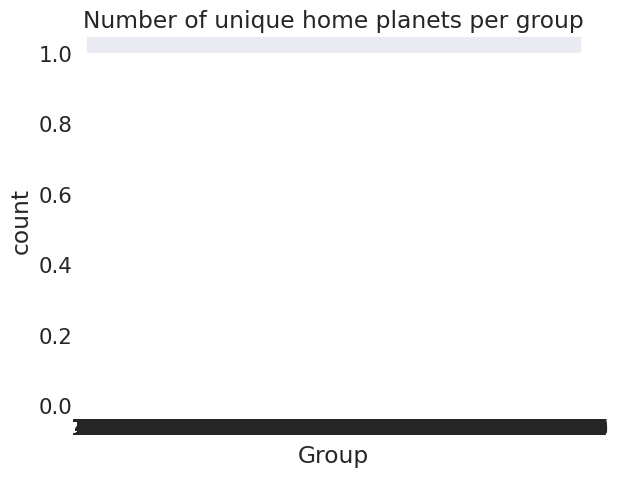

In [36]:
# Countplot of unique values
sns.countplot((GHP_gb>0).sum(axis=1))
plt.title('Number of unique home planets per group')

In [37]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a group with known HomePlanet
GHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Group']).isin(GHP_gb.index)].index

# Fill corresponding missing values
data.loc[GHP_index,'HomePlanet']=data.iloc[GHP_index,:]['Group'].map(lambda x: GHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 288
#HomePlanet missing values after: 157


<Axes: xlabel='Cabin_deck', ylabel='HomePlanet'>

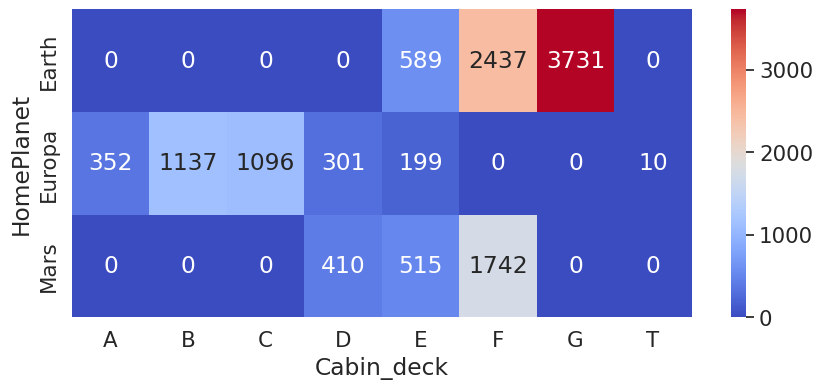

In [38]:
# Joint distribution of CabinDeck and HomePlanet
CDHP_gb=data.groupby(['Cabin_deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(CDHP_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [39]:
'''
Passengers on decks A, B, C or T came from Europa.
Passengers on deck G came from Earth.
Passengers on decks D, E or F came from multiple planets.
'''

# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='G'), 'HomePlanet']='Earth'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 157
#HomePlanet missing values after: 94


Text(0.5, 1.0, 'Number of unique planets per surname')

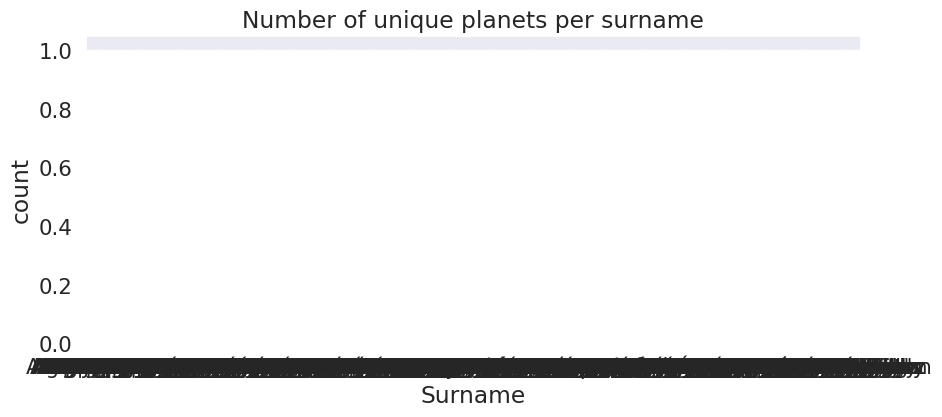

In [40]:
# Joint distribution of Surname and HomePlanet
SHP_gb=data.groupby(['Surname','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((SHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')

In [41]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
SHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Surname']).isin(SHP_gb.index)].index

# Fill corresponding missing values
data.loc[SHP_index,'HomePlanet']=data.iloc[SHP_index,:]['Surname'].map(lambda x: SHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

#HomePlanet missing values before: 94
#HomePlanet missing values after: 10


In [42]:
# Only 10 HomePlanet missing values left - let's look at them
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination']]

PassengerId HomePlanet  Destination
2274      2443_01        NaN  TRAPPIST-1e
2631      2817_01        NaN  TRAPPIST-1e
3091      3331_01        NaN  TRAPPIST-1e
4548      4840_01        NaN  TRAPPIST-1e
5762      6108_01        NaN  TRAPPIST-1e
8969      0616_01        NaN  TRAPPIST-1e
10583     4052_01        NaN  TRAPPIST-1e
11913     7065_01        NaN  TRAPPIST-1e
12551     8435_01        NaN  TRAPPIST-1e
12725     8775_01        NaN  TRAPPIST-1e

<Axes: xlabel='HomePlanet', ylabel='Destination'>

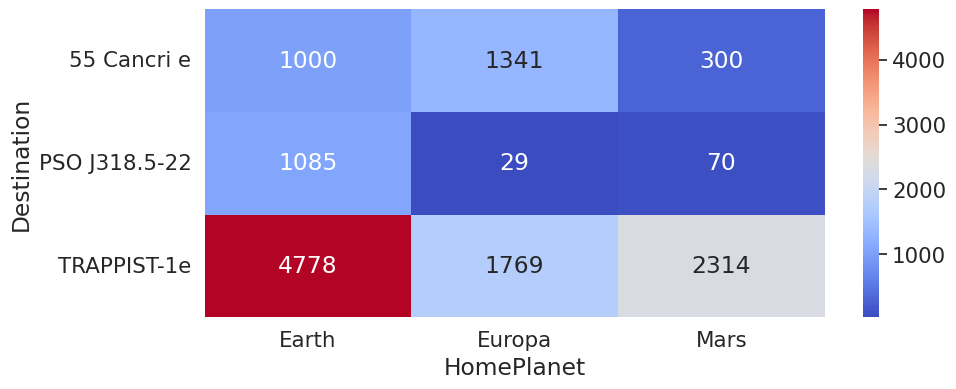

In [43]:
# Joint distribution of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of missing values
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')

In [44]:
'''
Most people heading towards TRAPPIST-1e came from Earth so it makes sense to guess they came from there. But remember from earlier, 
no one on deck D came from Earth so we need to filter these out.
'''

# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Cabin_deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Cabin_deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('#HomePlanet missing values before:',HP_bef)
print('#HomePlanet missing values after:',data['HomePlanet'].isna().sum())

# Awesome! We're done with HomePlanet.

#HomePlanet missing values before: 10
#HomePlanet missing values after: 0


In [45]:
'''
Destination

Since the majority (68%) of passengers are heading towards TRAPPIST-1e (see EDA section), we'll just impute this value (i.e. the mode). 
A better rule hasn't been found at this stage.
'''

# Missing values before
D_bef=data['Destination'].isna().sum()

# Fill missing Destination values with mode
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e'

# Print number of missing values left
print('#Destination missing values before:',D_bef)
print('#Destination missing values after:',data['Destination'].isna().sum())

#Destination missing values before: 274
#Destination missing values after: 0


Text(0.5, 1.0, 'Number of unique surnames by group')

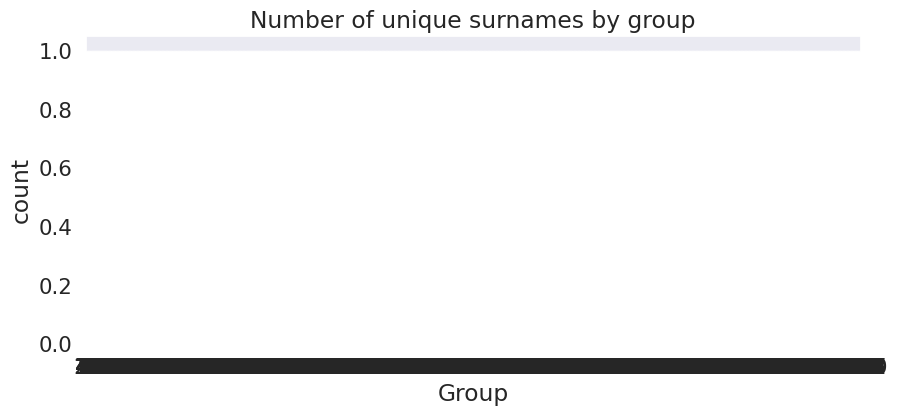

In [46]:
'''
Surname and group

The reason we are filling missing surnames is because we will use surnames later to fill missing values of other features. 
It also means we can improve the accuracy of the family size feature.
'''

# Joint distribution of Group and Surname
GSN_gb=data[data['Group_size']>1].groupby(['Group','Surname'])['Surname'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot((GSN_gb>0).sum(axis=1))
plt.title('Number of unique surnames by group')

In [47]:
# Missing values before
SN_bef=data['Surname'].isna().sum()

# Passengers with missing Surname and in a group with known majority Surname
GSN_index=data[data['Surname'].isna()][(data[data['Surname'].isna()]['Group']).isin(GSN_gb.index)].index

# Fill corresponding missing values
data.loc[GSN_index,'Surname']=data.iloc[GSN_index,:]['Group'].map(lambda x: GSN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Surname missing values before:',SN_bef)
print('#Surname missing values after:',data['Surname'].isna().sum())



#Surname missing values before: 294
#Surname missing values after: 155


In [50]:
'''
That is the best we can do. We don't have to get rid of all of these missing values because we will end up dropping the surname feature anyway. 
However, we can update the family size feature.
'''

# Replace NaN's with outliers (so we can use map)
data['Surname'].fillna('Unknown', inplace=True)

# Update family size feature
data['Family_size']=data['Surname'].map(lambda x: data['Surname'].value_counts()[x])

# Put NaN's back in place of outliers
data.loc[data['Surname']=='Unknown','Surname']=np.nan

# Say unknown surname means no family
data.loc[data['Family_size']>100,'Family_size']=0

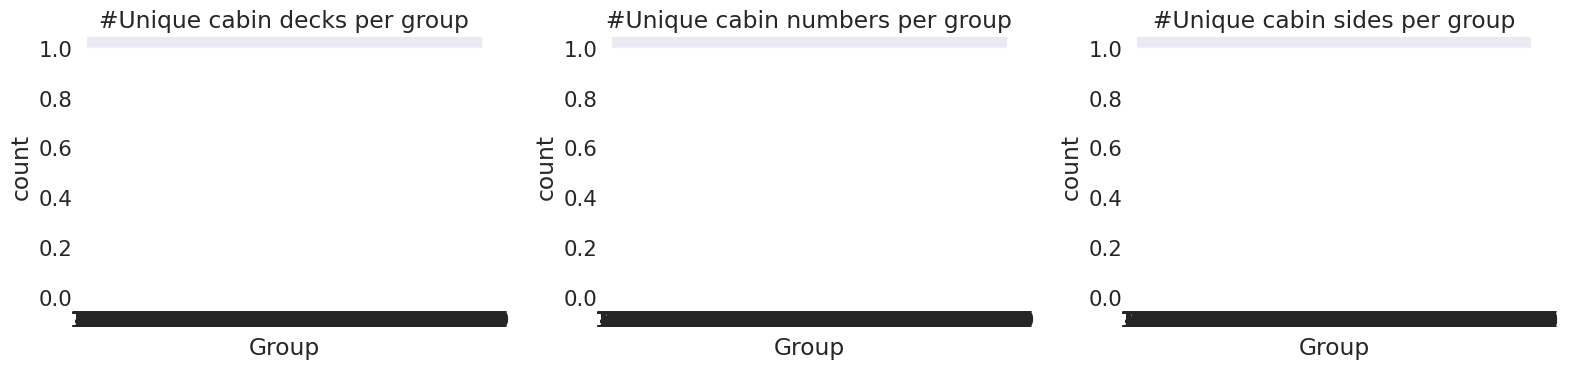

In [52]:
# CabinSide and Group



# Joint distribution of Group and Cabin features
GCD_gb=data[data['Group_size']>1].groupby(['Group','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)
GCN_gb=data[data['Group_size']>1].groupby(['Group','Cabin_number'])['Cabin_number'].size().unstack().fillna(0)
GCS_gb=data[data['Group_size']>1].groupby(['Group','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Countplots
fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((GCD_gb>0).sum(axis=1))
plt.title('#Unique cabin decks per group')

plt.subplot(1,3,2)
sns.countplot((GCN_gb>0).sum(axis=1))
plt.title('#Unique cabin numbers per group')

plt.subplot(1,3,3)
sns.countplot((GCS_gb>0).sum(axis=1))
plt.title('#Unique cabin sides per group')
fig.tight_layout()

In [53]:
'''
Another rule! Everyone in the same group is also on the same cabin side. 
For cabin deck and cabin number there is also a fairly good (but not perfect) correlation with group.
'''

# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Passengers with missing Cabin side and in a group with known Cabin side
GCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Group']).isin(GCS_gb.index)].index

# Fill corresponding missing values
data.loc[GCS_index,'Cabin_side']=data.iloc[GCS_index,:]['Group'].map(lambda x: GCS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 299
#Cabin_side missing values after: 162


Text(0.5, 1.0, 'Ratio of cabin side by surname')

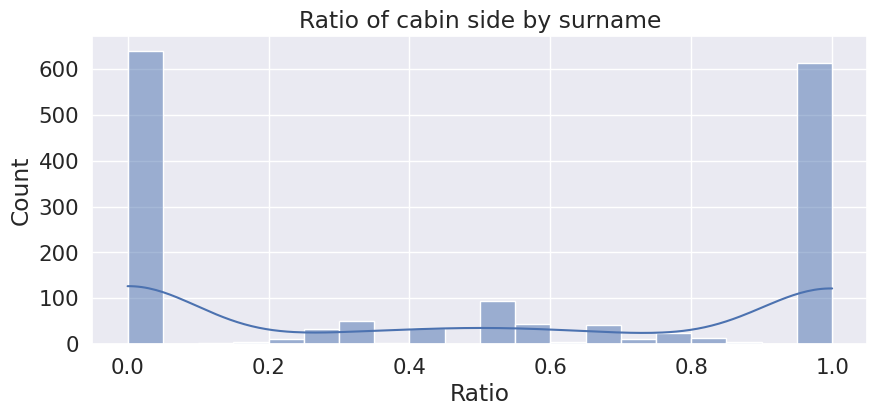

In [54]:
# CabinSide and Surname

# Joint distribution of Surname and Cabin side
SCS_gb=data[data['Group_size']>1].groupby(['Surname','Cabin_side'])['Cabin_side'].size().unstack().fillna(0)

# Ratio of sides
SCS_gb['Ratio']=SCS_gb['P']/(SCS_gb['P']+SCS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(SCS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of cabin side by surname')

In [55]:
# Print proportion
print('Percentage of families all on the same cabin side:', 100*np.round((SCS_gb['Ratio'].isin([0,1])).sum()/len(SCS_gb),3),'%')

# Another view of the same information
SCS_gb.head()

Percentage of families all on the same cabin side: 76.7 %


Cabin_side    P    S  Ratio
Surname                    
Acobson     0.0  3.0    0.0
Acobsond    3.0  0.0    1.0
Adavisons   6.0  0.0    1.0
Admingried  0.0  4.0    0.0
Aginge      3.0  0.0    1.0

In [56]:
'''
This shows that families tend to be on the same cabin side (and 77% of families are entirely on the same side).
'''

# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Drop ratio column
SCS_gb.drop('Ratio', axis=1, inplace=True)

# Passengers with missing Cabin side and in a family with known Cabin side
SCS_index=data[data['Cabin_side'].isna()][(data[data['Cabin_side'].isna()]['Surname']).isin(SCS_gb.index)].index

# Fill corresponding missing values
data.loc[SCS_index,'Cabin_side']=data.iloc[SCS_index,:]['Surname'].map(lambda x: SCS_gb.idxmax(axis=1)[x])

# Drop surname (we don't need it anymore)
data.drop('Surname', axis=1, inplace=True)

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 162
#Cabin_side missing values after: 66


In [57]:
'''
The remaining missing values will be replaced with an outlier. 
This is because we really don't know which one of the two (balanced) sides we should assign.
'''

# Value counts
data['Cabin_side'].value_counts()

Cabin_side
S    6504
P    6400
Name: count, dtype: int64

In [58]:
# Missing values before
CS_bef=data['Cabin_side'].isna().sum()

# Fill remaining missing values with outlier
data.loc[data['Cabin_side'].isna(),'Cabin_side']='Z'

# Print number of missing values left
print('#Cabin_side missing values before:',CS_bef)
print('#Cabin_side missing values after:',data['Cabin_side'].isna().sum())

#Cabin_side missing values before: 66
#Cabin_side missing values after: 0


In [59]:
'''
CabinDeck and Group

Remember (from above) that groups tend to be on the same cabin deck.
'''

# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
GCD_index=data[data['Cabin_deck'].isna()][(data[data['Cabin_deck'].isna()]['Group']).isin(GCD_gb.index)].index

# Fill corresponding missing values
data.loc[GCD_index,'Cabin_deck']=data.iloc[GCD_index,:]['Group'].map(lambda x: GCD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())

#Cabin_deck missing values before: 299
#Cabin_deck missing values after: 162


In [60]:
# CabinDeck and HomePlanet

# Joint distribution
data.groupby(['HomePlanet','Destination','Solo','Cabin_deck'])['Cabin_deck'].size().unstack().fillna(0)

Cabin_deck                         A      B      C      D      E       F  \
HomePlanet Destination   Solo                                              
Earth      55 Cancri e   0       0.0    0.0    0.0    0.0   20.0    90.0   
                         1       0.0    0.0    0.0    0.0   47.0   289.0   
           PSO J318.5-22 0       0.0    0.0    0.0    0.0   18.0    67.0   
                         1       0.0    0.0    0.0    0.0   25.0   262.0   
           TRAPPIST-1e   0       0.0    0.0    0.0    0.0  133.0   438.0   
                         1       0.0    0.0    0.0    0.0  358.0  1350.0   
Europa     55 Cancri e   0      96.0  377.0  313.0   59.0   35.0     0.0   
                         1      67.0  141.0  159.0   46.0   34.0     0.0   
           PSO J318.5-22 0       2.0    5.0   11.0    0.0    0.0     0.0   
                         1       0.0    0.0   10.0    0.0    0.0     0.0   
           TRAPPIST-1e   0     152.0  459.0  428.0  120.0   53.0     0.0   
                         1      44.0  179.0  201.0   84.0   82.0     0.0   
Mars       55 Cancri e   0       0.0    0.0    0.0   32.0   15.0   104.0   
                         1       0.0    0.0    0.0   40.0   16.0    92.0   
           PSO J318.5-22 0       0.0    0.0    0.0    8.0    9.0    14.0   
                         1       0.0    0.0    0.0    9.0    7.0    21.0   
           TRAPPIST-1e   0       0.0    0.0    0.0  168.0  219.0   798.0   
                         1       0.0    0.0    0.0  164.0  263.0   743.0   

Cabin_deck                          G    T  
HomePlanet Destination   Solo               
Earth      55 Cancri e   0      272.0  0.0  
                         1      269.0  0.0  
           PSO J318.5-22 0      230.0  0.0  
                         1      466.0  0.0  
           TRAPPIST-1e   0     1075.0  0.0  
                         1     1509.0  0.0  
Europa     55 Cancri e   0        0.0  2.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  1.0  
                         1        0.0  8.0  
Mars       55 Cancri e   0        0.0  0.0  
                         1        0.0  0.0  
           PSO J318.5-22 0        0.0  0.0  
                         1        0.0  0.0  
           TRAPPIST-1e   0        0.0  0.0  
                         1        0.0  0.0

In [61]:
'''
Passengers from Mars are most likely in deck F.
Passengers from Europa are (more or less) most likely in deck C if travelling solo and deck B otherwise.
Passengers from Earth are (more or less) most likely in deck G.

We will fill in missing values according to where the mode appears in these subgroups.
'''

# Missing values before
CD_bef=data['Cabin_deck'].isna().sum()

# Fill missing values using the mode
na_rows_CD=data.loc[data['Cabin_deck'].isna(),'Cabin_deck'].index
data.loc[data['Cabin_deck'].isna(),'Cabin_deck']=data.groupby(['HomePlanet','Destination','Solo'])['Cabin_deck'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CD]

# Print number of missing values left
print('#Cabin_deck missing values before:',CD_bef)
print('#Cabin_deck missing values after:',data['Cabin_deck'].isna().sum())



#Cabin_deck missing values before: 162
#Cabin_deck missing values after: 0


Text(0.5, 1.0, 'Cabin_number vs group coloured by group')

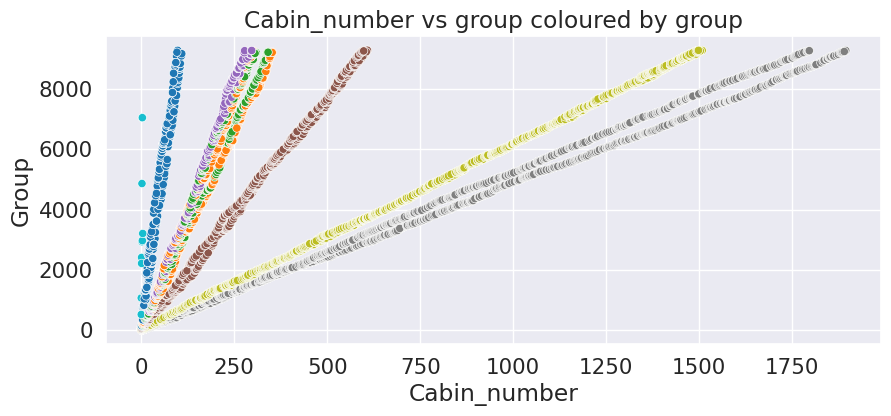

In [62]:
# CabinNumber and CabinDeck

# Scatterplot
plt.figure(figsize=(10,4))
sns.scatterplot(x=data['Cabin_number'], y=data['Group'], c=LabelEncoder().fit_transform(data.loc[~data['Cabin_number'].isna(),'Cabin_deck']), cmap='tab10')
plt.title('Cabin_number vs group coloured by group')

In [63]:
'''
There is an interesting pattern here. The cabin_number and group_number share a linear relationship on a deck by deck basis. 
We can therefore extrapolate the missing cabin numbers using linear regression on a deck by deck basis to get an approximate cabin number.
'''

# Missing values before
CN_bef=data['Cabin_number'].isna().sum()

# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Features and labels
    X_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']
    y_CN=data.loc[~(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']
    X_test_CN=data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Group']

    # Linear regression
    model_CN=LinearRegression()
    model_CN.fit(X_CN.values.reshape(-1, 1), y_CN)
    preds_CN=model_CN.predict(X_test_CN.values.reshape(-1, 1))
    
    # Fill missing values with predictions
    data.loc[(data['Cabin_number'].isna()) & (data['Cabin_deck']==deck),'Cabin_number']=preds_CN.astype(int)

# Print number of missing values left
print('#Cabin_number missing values before:',CN_bef)
print('#Cabin_number missing values after:',data['Cabin_number'].isna().sum())

#Cabin_number missing values before: 299
#Cabin_number missing values after: 0


In [64]:
# Let's update the cabin regions with the new data.

# One-hot encode cabin regions
data['Cabin_region1']=(data['Cabin_number']<300).astype(int)
data['Cabin_region2']=((data['Cabin_number']>=300) & (data['Cabin_number']<600)).astype(int)
data['Cabin_region3']=((data['Cabin_number']>=600) & (data['Cabin_number']<900)).astype(int)
data['Cabin_region4']=((data['Cabin_number']>=900) & (data['Cabin_number']<1200)).astype(int)
data['Cabin_region5']=((data['Cabin_number']>=1200) & (data['Cabin_number']<1500)).astype(int)
data['Cabin_region6']=((data['Cabin_number']>=1500) & (data['Cabin_number']<1800)).astype(int)
data['Cabin_region7']=(data['Cabin_number']>=1800).astype(int)

In [65]:
'''
VIP

VIP is a highly unbalanced binary feature so we will just impute the mode.

'''

data['VIP'].value_counts()

VIP
False    12401
True       273
Name: count, dtype: int64

In [66]:
# Missing values before
V_bef=data['VIP'].isna().sum()

# Fill missing values with mode
data.loc[data['VIP'].isna(),'VIP']=False

# Print number of missing values left
print('#VIP missing values before:',V_bef)
print('#VIP missing values after:',data['VIP'].isna().sum())

#VIP missing values before: 296
#VIP missing values after: 0


In [67]:
'''
Age

Age varies across many features like HomePlanet, 
group size, expenditure and cabin deck, 
so we will impute missing values according to the median of these subgroups.
'''

# Joint distribution
data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].median().unstack().fillna(0)

Cabin_deck                      A     B     C     D     E     F     G     T
HomePlanet No_spending Solo                                                
Earth      0           0      0.0   0.0   0.0   0.0  24.0  25.0  28.0   0.0
                       1      0.0   0.0   0.0   0.0  25.0  24.0  26.0   0.0
           1           0      0.0   0.0   0.0   0.0   7.0  16.0   8.0   0.0
                       1      0.0   0.0   0.0   0.0  21.0  21.5  23.0   0.0
Europa     0           0     35.0  34.0  33.0  33.0  34.0   0.0   0.0  44.0
                       1     35.0  36.0  35.5  34.0  35.0   0.0   0.0  35.0
           1           0     30.0  27.0  28.5  27.0  28.0   0.0   0.0   0.0
                       1     37.5  34.0  35.0  31.0  33.0   0.0   0.0   0.0
Mars       0           0      0.0   0.0   0.0  30.0  29.0  29.0   0.0   0.0
                       1      0.0   0.0   0.0  31.0  28.5  30.0   0.0   0.0
           1           0      0.0   0.0   0.0  29.5  26.0  18.0   0.0   0.0
                       1      0.0   0.0   0.0  33.0  30.0  29.5   0.0   0.0

In [68]:
# Missing values before
A_bef=data[exp_feats].isna().sum().sum()

# Fill missing values using the median
na_rows_A=data.loc[data['Age'].isna(),'Age'].index
data.loc[data['Age'].isna(),'Age']=data.groupby(['HomePlanet','No_spending','Solo','Cabin_deck'])['Age'].transform(lambda x: x.fillna(x.median()))[na_rows_A]

# Print number of missing values left
print('#Age missing values before:',A_bef)
print('#Age missing values after:',data['Age'].isna().sum())

#Age missing values before: 1410
#Age missing values after: 0


In [69]:
# Let's update the age_group feature using the new data.

# Update age group feature
data.loc[data['Age']<=12,'Age_group']='Age_0-12'
data.loc[(data['Age']>12) & (data['Age']<18),'Age_group']='Age_13-17'
data.loc[(data['Age']>=18) & (data['Age']<=25),'Age_group']='Age_18-25'
data.loc[(data['Age']>25) & (data['Age']<=30),'Age_group']='Age_26-30'
data.loc[(data['Age']>30) & (data['Age']<=50),'Age_group']='Age_31-50'
data.loc[data['Age']>50,'Age_group']='Age_51+'

In [70]:
'''
CryoSleep

The best way to predict if a passenger is in CryoSleep or not is to see if they spent anything.
'''

# Joint distribution
data.groupby(['No_spending','CryoSleep'])['CryoSleep'].size().unstack().fillna(0)

CryoSleep     False   True 
No_spending                
0            7339.0     0.0
1             740.0  4581.0

In [71]:
# Missing values before
CSL_bef=data['CryoSleep'].isna().sum()

# Fill missing values using the mode
na_rows_CSL=data.loc[data['CryoSleep'].isna(),'CryoSleep'].index
data.loc[data['CryoSleep'].isna(),'CryoSleep']=data.groupby(['No_spending'])['CryoSleep'].transform(lambda x: x.fillna(pd.Series.mode(x)[0]))[na_rows_CSL]

# Print number of missing values left
print('#CryoSleep missing values before:',CSL_bef)
print('#CryoSleep missing values after:',data['CryoSleep'].isna().sum())

#CryoSleep missing values before: 310
#CryoSleep missing values after: 0


In [72]:
'''
Expenditure and CryoSleep

This one makes a lot of sense. We don't expect people in CryoSleep to be able to spend anything.
'''

print('Maximum expenditure of passengers in CryoSleep:',data.loc[data['CryoSleep']==True,exp_feats].sum(axis=1).max())

Maximum expenditure of passengers in CryoSleep: 0.0


In [73]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# CryoSleep has no expenditure
for col in exp_feats:
    data.loc[(data[col].isna()) & (data['CryoSleep']==True), col]=0

# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 1410
#Expenditure missing values after: 866


In [74]:
'''
Expenditure and others

Expenditure varies across many features but we will only impute missing values using HomePlanet, 
Solo and Age group to prevent overfitting. 
We will also use the mean instead of the median because a large proportion of passengers don't spend anything and median usually comes out as 0.
 Note how under 12's don't spend anything.
'''

# Joint distribution
data.groupby(['HomePlanet','Solo','Age_group'])['Expenditure'].mean().unstack().fillna(0)

Age_group        Age_0-12    Age_13-17    Age_18-25    Age_26-30    Age_31-50  \
HomePlanet Solo                                                                 
Earth      0          0.0   724.902222   789.700555   841.093596   736.655773   
           1          0.0   693.014898   779.395942   795.420690   794.818627   
Europa     0          0.0  1153.160256  2652.013298  3534.668246  3975.774005   
           1          0.0     0.000000  2489.888889  3806.000000  3949.939929   
Mars       0          0.0  1176.839286  1161.808333  1247.098361  1143.671916   
           1          0.0  1687.261538  1075.341146  1107.122677  1110.392045   

Age_group            Age_51+  
HomePlanet Solo               
Earth      0      733.649573  
           1      826.366972  
Europa     0     3483.639004  
           1     3952.085526  
Mars       0     1345.419643  
           1     1100.298387

In [75]:
# Missing values before
E_bef=data[exp_feats].isna().sum().sum()

# Fill remaining missing values using the median
for col in exp_feats:
    na_rows=data.loc[data[col].isna(),col].index
    data.loc[data[col].isna(),col]=data.groupby(['HomePlanet','Solo','Age_group'])[col].transform(lambda x: x.fillna(x.mean()))[na_rows]
    
# Print number of missing values left
print('#Expenditure missing values before:',E_bef)
print('#Expenditure missing values after:',data[exp_feats].isna().sum().sum())

#Expenditure missing values before: 866
#Expenditure missing values after: 0


In [76]:
# Finally, we can update the expenditure and no_spending features with these new data points.

# Update expenditure and no_spending
data['Expenditure']=data[exp_feats].sum(axis=1)
data['No_spending']=(data['Expenditure']==0).astype(int)

data.isna().sum()

PassengerId      0
HomePlanet       0
CryoSleep        0
Destination      0
Age              0
VIP              0
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
Age_group        0
Expenditure      0
No_spending      0
Group            0
Group_size       0
Solo             0
Cabin_deck       0
Cabin_number     0
Cabin_side       0
Cabin_region1    0
Cabin_region2    0
Cabin_region3    0
Cabin_region4    0
Cabin_region5    0
Cabin_region6    0
Cabin_region7    0
Family_size      0
dtype: int64

In [77]:
# Train and test
X=data[data['PassengerId'].isin(train_df['PassengerId'].values)].copy()
X_test=data[data['PassengerId'].isin(test_df['PassengerId'].values)].copy()

In [78]:
# Drop unwanted features

# Drop qualitative/redundant/collinear/high cardinality features
X.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Group', 'Group_size', 'Age_group', 'Cabin_number'], axis=1, inplace=True)

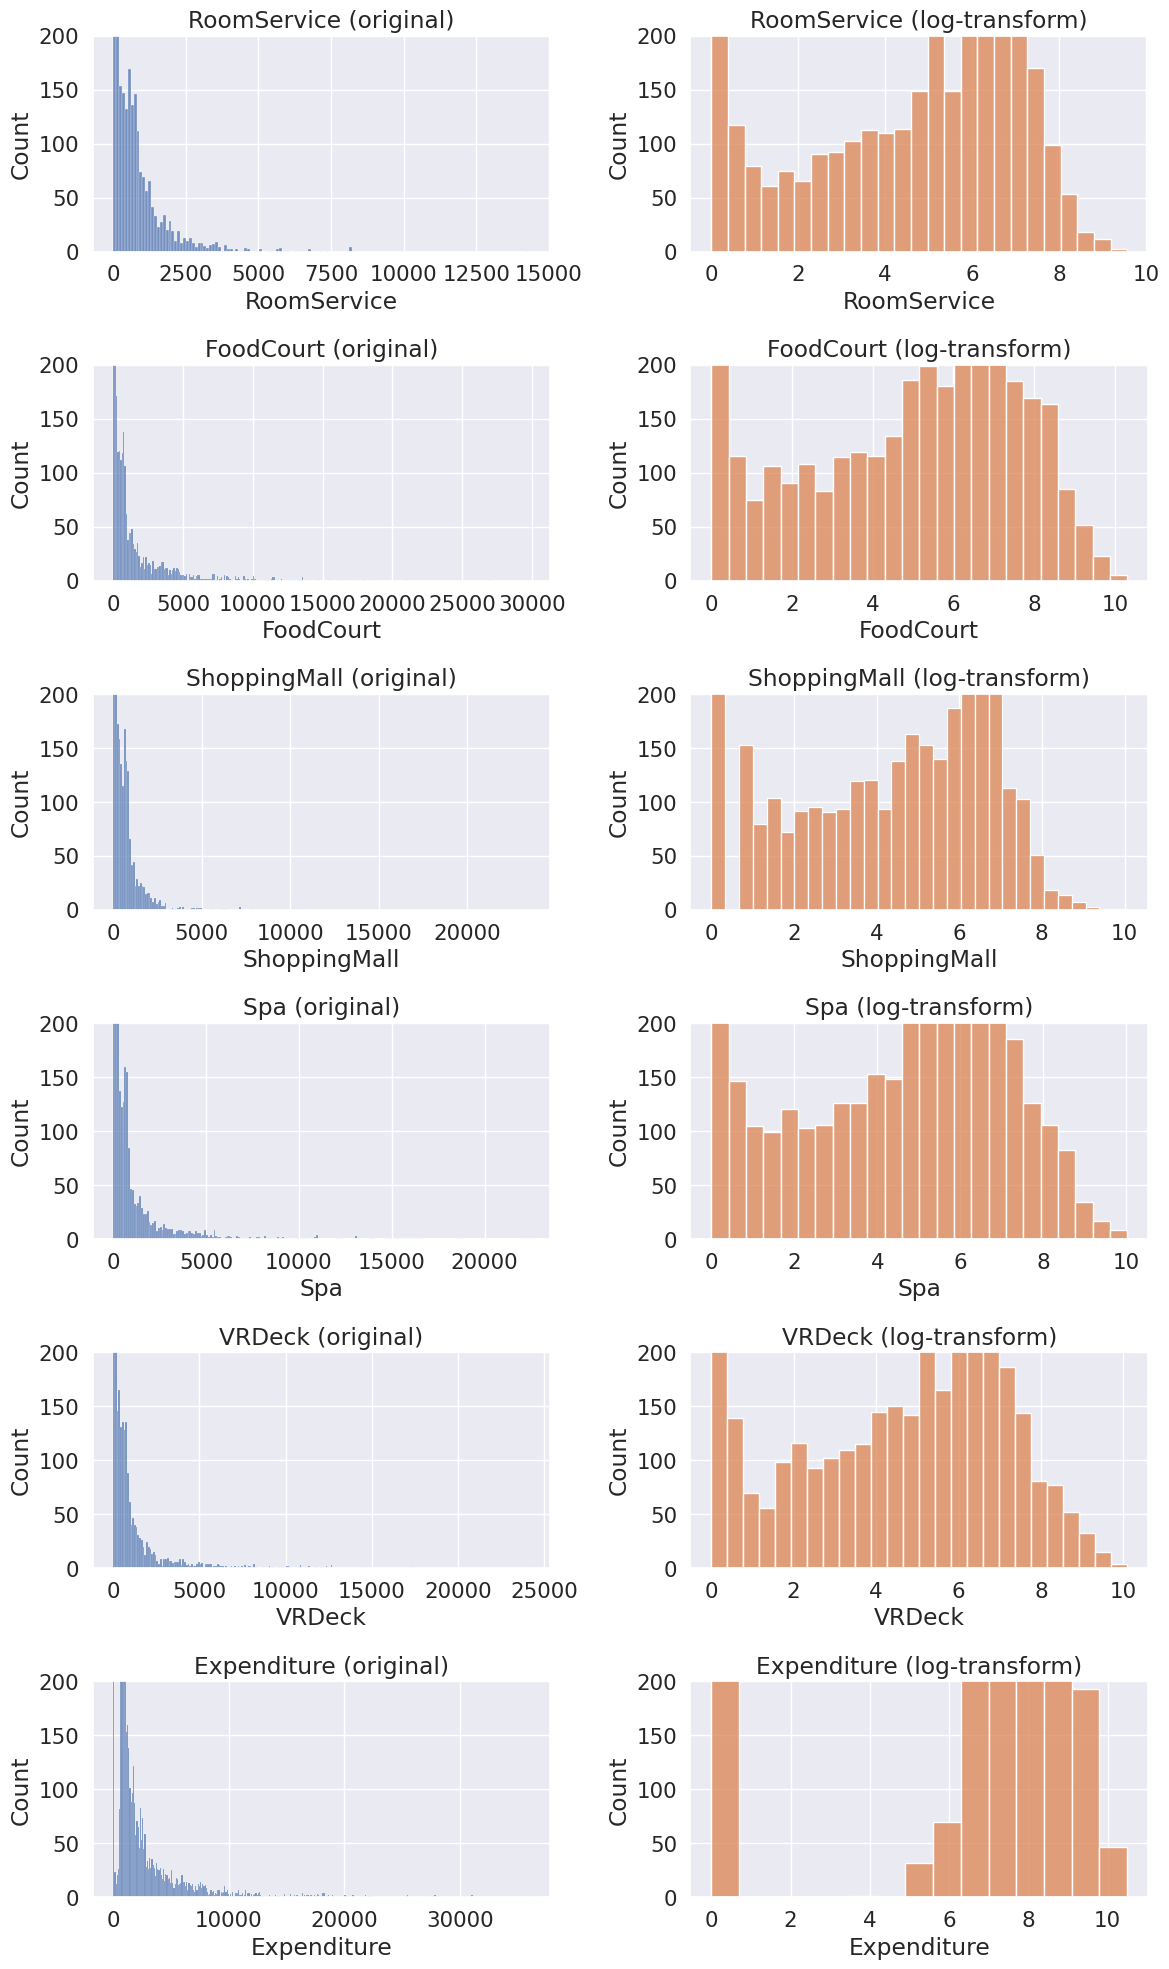

In [79]:
'''
Log transform

The logarithm transform is used to decrease skew in distributions, especially with large outliers. 
It can make it easier for algorithms to 'learn' the correct relationships. 
We will apply it to the expenditure features as these are heavily skewed by outliers.
'''

# Plot log transform results
fig=plt.figure(figsize=(12,20))
for i, col in enumerate(['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']):
    plt.subplot(6,2,2*i+1)
    sns.histplot(X[col], binwidth=100)
    plt.ylim([0,200])
    plt.title(f'{col} (original)')
    
    plt.subplot(6,2,2*i+2)
    sns.histplot(np.log(1+X[col]), color='C1')
    plt.ylim([0,200])
    plt.title(f'{col} (log-transform)')
    
fig.tight_layout()
plt.show()

In [80]:
# Apply log transform
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    X[col]=np.log(1+X[col])
    X_test[col]=np.log(1+X_test[col])

In [81]:
'''
Encoding and scaling

We will use column transformers to be more professional. It's also good practice.
'''

# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)
X_test = ct.transform(X_test)

# Print new shape
print('Training set shape:', X.shape)

Training set shape: (8693, 36)


In [82]:
'''
PCA

Just for fun, let's look at the transformed data in PCA space. 
This gives a low dimensional representation of the data, 
which preserves local and global structure.
'''

pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y, size=0.1*np.ones(len(X)), opacity = 1,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    width=800, height=500
)
fig.show()

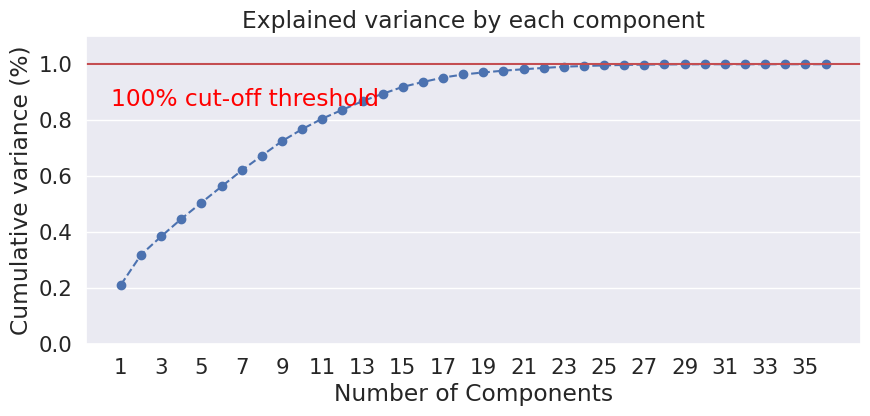

In [83]:
# Explained variance (how important each additional principal component is)
pca = PCA().fit(X)
fig, ax = plt.subplots(figsize=(10,4))
xi = np.arange(1, 1+X.shape[1], step=1)
yi = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

# Aesthetics
plt.ylim(0.0,1.1)
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 1+X.shape[1], step=2))
plt.ylabel('Cumulative variance (%)')
plt.title('Explained variance by each component')
plt.axhline(y=1, color='r', linestyle='-')
plt.text(0.5, 0.85, '100% cut-off threshold', color = 'red')
ax.grid(axis='x')

In [84]:
'''
Create a validation set

We will use this to choose which model(s) to use.
'''

# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [85]:
'''
Model selection
To briefly mention the algorithms we will use,

Logistic Regression: Unlike linear regression which uses Least Squares, this model uses Maximum Likelihood Estimation to fit a sigmoid-curve on the target variable distribution. The sigmoid/logistic curve is commonly used when the data is questions had binary output.

K-Nearest Neighbors (KNN): KNN works by selecting the majority class of the k-nearest neighbours, where the metric used is usually Euclidean distance. It is a simple and effective algorithm but can be sensitive by many factors, e.g. the value of k, the preprocessing done to the data and the metric used.

Support Vector Machine (SVM): SVM finds the optimal hyperplane that seperates the data in the feature space. Predictions are made by looking at which side of the hyperplane the test point lies on. Ordinary SVM assumes the data is linearly separable, which is not always the case. A kernel trick can be used when this assumption fails to transform the data into a higher dimensional space where it is linearly seperable. SVM is a popular algorithm because it is computationally effecient and produces very good results.

Random Forest (RF): RF is a reliable ensemble of decision trees, which can be used for regression or classification problems. Here, the individual trees are built via bagging (i.e. aggregation of bootstraps which are nothing but multiple train datasets created via sampling with replacement) and split using fewer features. The resulting diverse forest of uncorrelated trees exhibits reduced variance; therefore, is more robust towards change in data and carries its prediction accuracy to new data. It works well with both continuous & categorical data.

Extreme Gradient Boosting (XGBoost): XGBoost is similar to RF in that it is made up of an ensemble of decision-trees. The difference arises in how those trees as derived; XGboost uses extreme gradient boosting when optimising its objective function. It often produces the best results but is relatively slow compared to other gradient boosting algorithms.

Light Gradient Boosting Machine (LGBM): LGBM works essentially the same as XGBoost but with a lighter boosting technique. It usually produces similar results to XGBoost but is significantly faster.

Categorical Boosting (CatBoost): CatBoost is an open source algorithm based on gradient boosted decision trees. It supports numerical, categorical and text features. It works well with heterogeneous data and even relatively small data. Informally, it tries to take the best of both worlds from XGBoost and LGBM.

Naive Bayes (NB): Naive Bayes learns how to classify samples by using Bayes' Theorem. It uses prior information to 'update' the probability of an event by incoorporateing this information according to Bayes' law. The algorithm is quite fast but a downside is that it assumes the input features are independent, which is not always the case.

We will train these models and evaluate them on the validation set to then choose which ones to carry through to the next stage (cross validation).
'''

"\nModel selection\nTo briefly mention the algorithms we will use,\n\nLogistic Regression: Unlike linear regression which uses Least Squares, this model uses Maximum Likelihood Estimation to fit a sigmoid-curve on the target variable distribution. The sigmoid/logistic curve is commonly used when the data is questions had binary output.\n\nK-Nearest Neighbors (KNN): KNN works by selecting the majority class of the k-nearest neighbours, where the metric used is usually Euclidean distance. It is a simple and effective algorithm but can be sensitive by many factors, e.g. the value of k, the preprocessing done to the data and the metric used.\n\nSupport Vector Machine (SVM): SVM finds the optimal hyperplane that seperates the data in the feature space. Predictions are made by looking at which side of the hyperplane the test point lies on. Ordinary SVM assumes the data is linearly separable, which is not always the case. A kernel trick can be used when this assumption fails to transform the 

In [86]:
# Define classifiers

# Classifiers
classifiers = {
    # "LogisticRegression" : LogisticRegression(random_state=0),
    # "KNN" : KNeighborsClassifier(),
    # "SVC" : SVC(random_state=0, probability=True),
    # "RandomForest" : RandomForestClassifier(random_state=0),
    # "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    # "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    # "LGBM" : LGBMClassifier(random_state=0, force_col_wise=True),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False),
    # "NaiveBayes": GaussianNB()
}

# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

SVC_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

NB_grid={'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "SVC" : SVC_grid,
    "RandomForest" : RF_grid,
    "GradientBoostingClassifier": boosted_grid,
    "XGBoost" : boosted_grid,
    "LGBM" : boosted_grid,
    "CatBoost" : boosted_grid,
    "NaiveBayes": NB_grid
}

In [87]:
'''
Train and evaluate models

Train models with grid search (but no cross validation so it doesn't take too long) to get a rough idea of which are the best models for this dataset.
'''

i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=8, cv=None, verbose=2)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   1.4s
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   1.4s
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   1.3s
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   1.2s
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   2.4s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   3.1s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   3.4s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   3.7s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=150; total time=   4.6s
[CV] END ..learning_rate=0.05, max_depth=4, n_e

In [88]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [89]:
# Show results
valid_scores

Classifer  Validation accuracy  Training time
0  CatBoost             0.807361           9.89

In [ ]:
'''
Motivated by this, we will take LGBM and CatBoost to the final stage of modelling.


'''

# Show best parameters from grid search
clf_best_params

In [90]:
'''
Modelling
We can finally train our best model on the whole training set using cross validation and ensembling predictions 
together to produce the most confident predictions.

Define best models
'''

# Classifiers
best_classifiers = {
    # "XGBoost" : XGBClassifier(**clf_best_params["XGBoost"], random_state=0),
    "CatBoost" : CatBoostClassifier(**clf_best_params["CatBoost"], verbose=2, random_state=0),
    # "LGBM": GradientBoostingClassifier(**clf_best_params["LGBM"], verbose=2, random_state=0)
}

In [91]:
'''
Cross validation and ensembling predictions

Predictions are ensembled together using soft voting. This averages the predicted probabilies to produce the most confident predictions.
'''

# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(X_test))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 10-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(X_test)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

0:	learn: 0.6345040	total: 3.3ms	remaining: 327ms
2:	learn: 0.5641686	total: 10.3ms	remaining: 334ms
4:	learn: 0.5220098	total: 16.1ms	remaining: 306ms
6:	learn: 0.4998844	total: 21.9ms	remaining: 291ms
8:	learn: 0.4833918	total: 27.8ms	remaining: 281ms
10:	learn: 0.4695652	total: 34.1ms	remaining: 276ms
12:	learn: 0.4533633	total: 40.3ms	remaining: 269ms
14:	learn: 0.4459813	total: 46.7ms	remaining: 264ms
16:	learn: 0.4400861	total: 52.8ms	remaining: 258ms
18:	learn: 0.4323328	total: 59.1ms	remaining: 252ms
20:	learn: 0.4280224	total: 66.5ms	remaining: 250ms
22:	learn: 0.4247654	total: 74.5ms	remaining: 249ms
24:	learn: 0.4210678	total: 83.7ms	remaining: 251ms
26:	learn: 0.4188598	total: 89.9ms	remaining: 243ms
28:	learn: 0.4140829	total: 97.9ms	remaining: 240ms
30:	learn: 0.4108111	total: 104ms	remaining: 232ms
32:	learn: 0.4079896	total: 113ms	remaining: 229ms
34:	learn: 0.4057973	total: 119ms	remaining: 222ms
36:	learn: 0.4045325	total: 127ms	remaining: 215ms
38:	learn: 0.4017265	t

Text(0.5, 0, 'Probability')

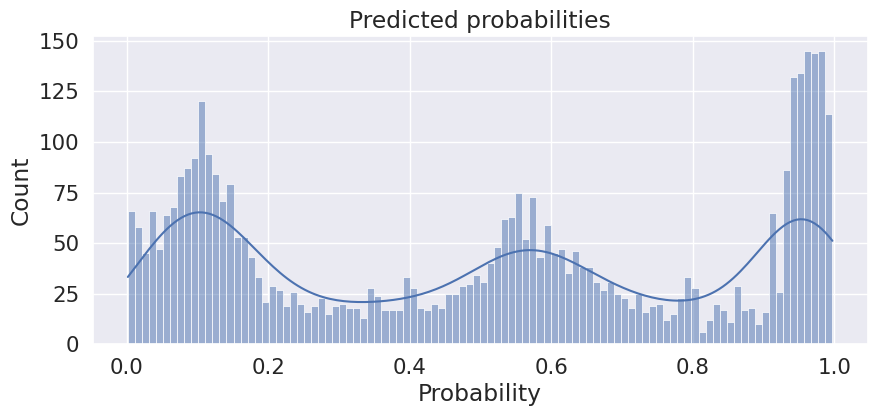

In [92]:
'''
Submission
Let's look at the distribution of the predicted probabilities.
'''

plt.figure(figsize=(10,4))
sns.histplot(preds, binwidth=0.01, kde=True)
plt.title('Predicted probabilities')
plt.xlabel('Probability')

# It is interesting to see that the models are either very confident or very unconfident but not much in between.

In [ ]:
'''
Post processing

Finally, we need to convert each predicted probability into one of the two classes (transported or not). The simplest way is to round each probability to the nearest integer (0 for False or 1 for True). However, assuming the train and test sets have similar distributions, we can tune the classification threshold to obtain a similar proportion of transported/not transported in our predictions as in the train set. Remember that the proportion of transported passengers in the train set was 50.4%.
'''

Optimal threshold: 0.518


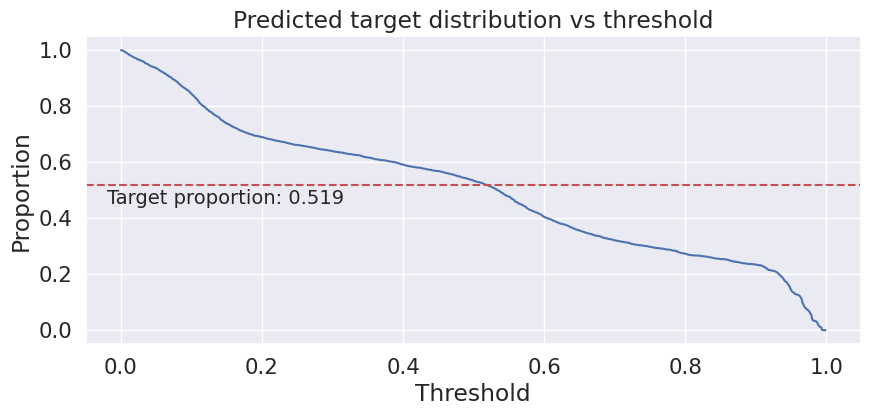

In [93]:
# Proportion of predicted positive (transported) classes
def preds_prop(preds_arr, thresh):
    pred_classes=(preds_arr>=thresh).astype(int)
    return pred_classes.sum()/len(pred_classes)

# Plot proportions across a range of thresholds
def plot_preds_prop(preds_arr):
    # Array of thresholds
    T_array=np.arange(0,1,0.001)
    
    # Calculate proportions
    prop=np.zeros(len(T_array))
    for i, T in enumerate(T_array):
        prop[i]=preds_prop(preds_arr, T)
        
    # Plot proportions
    plt.figure(figsize=(10,4))
    plt.plot(T_array, prop)
    target_prop=0.519         # Experiment with this value
    plt.axhline(y=target_prop, color='r', linestyle='--')
    plt.text(-0.02,0.45,f'Target proportion: {target_prop}', fontsize=14)
    plt.title('Predicted target distribution vs threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Proportion')
    
    # Find optimal threshold (the one that leads to the proportion being closest to target_prop)
    T_opt=T_array[np.abs(prop-target_prop).argmin()]
    print('Optimal threshold:', T_opt)
    return T_opt
    
T_opt=plot_preds_prop(preds)

In [94]:
# Classify test set using optimal threshold
preds_tuned=(preds>=T_opt).astype(int)

Text(0.5, 1.0, 'Prediction distribution')

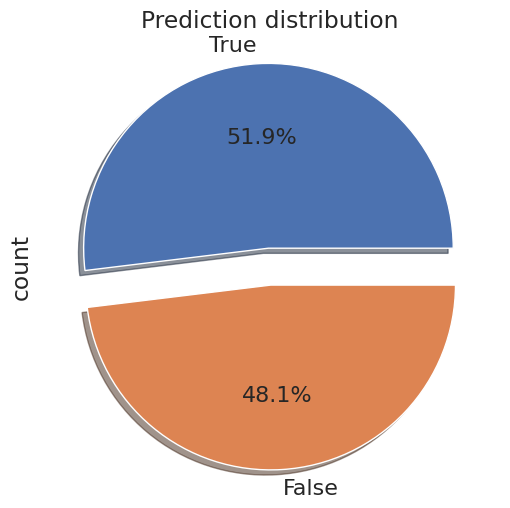

In [95]:
# Sample submission (to get right format)
sub=pd.read_csv('./dataset//sample_submission.csv')

# Add predictions
sub['Transported']=preds_tuned

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Prediction distribution
plt.figure(figsize=(6,6))
sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")

In [96]:
# Output to csv
sub.to_csv('submission_8113CB.csv', index=False)

In [97]:
with open('submission_8113CB.csv', 'r') as t1, open('submission_8117CB.csv', 'r') as t2:
    fileone = t1.readlines()
    filetwo = t2.readlines()

with open('diff.csv', 'w') as outFile:
    for line in filetwo:
        if line not in fileone:
            outFile.write(line)